In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

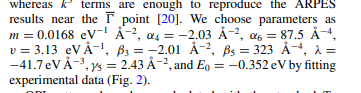

In [2]:
Par = np.array([0.0168, -2.03, 87.5, 3.13, -2.01, 323, -41.7, 2.43, -0.352])

In [3]:
N = 800; #16
om = -0.01;
k_spacex, k_spacey = np.mgrid[-1.5:1.5:N*1j,-1.5:1.5:N*1j]
#k_spacex1, k_spacey1 = np.ogrid[-1.5:1.5:500j,-1.5:1.5:500j]
test = [k_spacex, k_spacey]
var = np.zeros([len(k_spacex),len(k_spacex)])



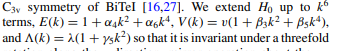

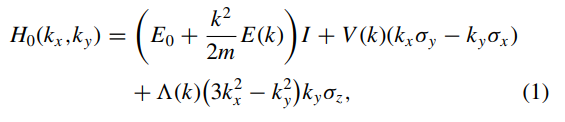

In [4]:
σx = np.array([[0, 1],[1, 0]]); σy = np.array([[0, -1j],[1j, 0]]); σz = np.array([[1, 0],[0, -1]])

def H(kr, p = Par):
    k_x, k_y = kr
    m, α4, α6, v, β3, β5, λ, γ5, E0 = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x;
    ksq = k_x**2+k_y**2
    Ek = 1+α4*ksq+α6*ksq**2; Vk = v*(1+β3*ksq+β5*ksq**2); Λ = λ*(1+γ5*ksq)
    return (E0+ksq/(2*m)*Ek)*np.eye(2)+Vk*(k_x*σy-k_y*σx)+Λ*(3*k_x**2-k_y**2)*k_y*σz

print(H([0.2,1.1]))

[[ 5230.58049637  +0.j      -1732.431525  -314.98755j]
 [-1732.431525  +314.98755j  4826.84422387  +0.j     ]]


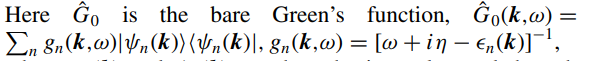

In [5]:
from numpy import linalg as LA
η = 0.01
def G0(k, ω = om):
    kx, ky = k
    Ham = H(k); 
    λ, v = LA.eig(Ham)
    summ = np.zeros([2,2])
    for n in range(len(λ)):
        g = (ω+1j*0.01-λ[n])**(-1)
        ψ = v[n]
        summ = summ+g*np.matmul(np.transpose(ψ), np.conj(ψ))
    return summ
print(G0([0.0,0.0], 0.01))       

[[5.52064906-0.15250412j 5.52064906-0.15250412j]
 [5.52064906-0.15250412j 5.52064906-0.15250412j]]


In [6]:
length = 0.6
k_spacex3, k_spacey3 = np.mgrid[-length:length:N*1j,-length:length:N*1j]

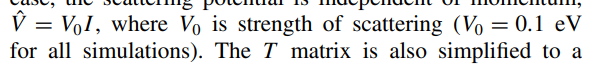

(scalar)

In [7]:
V = 0.1*np.eye(2)
print(V[0,0])

0.1


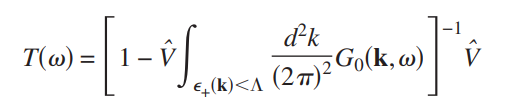

(Momentum-independent)

In [8]:
from numpy.linalg import inv
def T(ω = om):
    summm = np.zeros([2,2])
    for i in tqdm(range(N), desc="T-Matrix"):
        for j in range(N):
            summm = summm + G0([k_spacex3[i, j], k_spacey3[i, j]], ω)
    return np.matmul(inv(np.eye(2)-np.matmul(V, summm)), V)

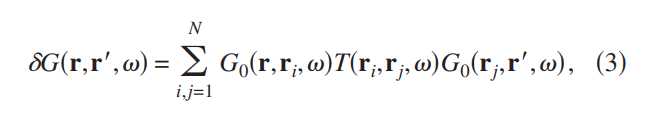
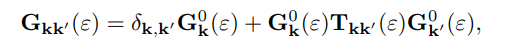

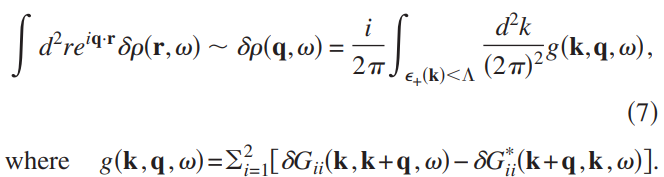

In [9]:
T1 = T(om) #outside of function speeds up

T-Matrix: 100%|██████████| 800/800 [00:49<00:00, 16.26it/s]


In [10]:
# def DOS(q, ω = om):
#     #G1 = G(k, k+q)
#     #G2 = (-1*G(k+q, k)).getH()
#     summ = 0+0*1j
#     for i in range(N):
#         for j in range(N):
#             k = np.array([k_spacex3[i,j], k_spacey3[i,j]])
#             G0k = G0M[i,j]
#             G0kq = np.roll(G0M, 
#             G0kq1 = G0kq[i,j]
#             G1 = np.trace(G(G0k, G0(k+q, om)))
#             G2 = -1*np.trace(G(G0(k+q, om), G0k).conj().T)
#             summ = summ+G1+G2
#     return np.real(1j*summ/(2*np.pi)**3)
# #go = DOS(np.array([0,1]))
# print(DOS(np.array([0,1])))
print(T1[0,])

[ 0.0500002-3.07134957e-07j -0.0499998-3.07134740e-07j]


In [11]:
sol = np.zeros((N,N))


In [12]:
G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mp[i,j] = G0([k_spacex3[i, j], k_spacey3[i, j] ], om)

G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mm[i,j] = G0([-1*k_spacex3[i, j], -1*k_spacey3[i, j] ], om)
            

G0-Matrix: 100%|██████████| 800/800 [00:57<00:00, 13.83it/s]


In [13]:
G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')

for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mpconj[i,j] = G0Mp[i,j].conj().T
            
for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mmconj[i,j] = G0Mp[i,j].conj().T

print()

G0-Matrix HT: 100%|██████████| 800/800 [00:01<00:00, 749.86it/s]

In [14]:
#print(G0M[:,:,0,0])
def DOS(w = om):
    fact = 1j/(2*np.pi)**3/N
    res = np.zeros([N,N], dtype = 'complex')

    T2 = T1.conj()
    
    for m in range(2):
        for n in range(2):
            for j in tqdm(range(2), desc="G0-Matrix"):
                Gp1 = (np.fft.fft2(fftshift(G0Mp[:,:,n,j])))
                Gm1 = (np.fft.fft2(fftshift(G0Mm[:,:,j,m])))
                G1 = np.fft.ifft2((np.multiply((Gp1),(Gm1))))
                Gp2 = (np.fft.fft2(fftshift(G0Mpconj[:,:,j,m])))
                Gm2 = (np.fft.fft2(fftshift(G0Mmconj[:,:,n,j])))
                G2 = np.fft.ifft2((np.multiply(Gp2,Gm2)))
            res = res+T1[m,n]*(G1)-(T2[m,n]*(G2))
    
    sol = (np.abs(ifftshift(fact*res)))
    return sol

In [15]:
sol = DOS()
print(sol)

G0-Matrix: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

[[3.03480440e-07 3.03552542e-07 3.03672720e-07 ... 3.03552542e-07
  3.03480440e-07 3.03456407e-07]
 [3.03542481e-07 3.03614607e-07 3.03734827e-07 ... 3.03614607e-07
  3.03542481e-07 3.03518440e-07]
 [3.03645892e-07 3.03718059e-07 3.03838348e-07 ... 3.03718059e-07
  3.03645892e-07 3.03621837e-07]
 ...
 [3.03542481e-07 3.03614607e-07 3.03734827e-07 ... 3.03614607e-07
  3.03542481e-07 3.03518440e-07]
 [3.03480440e-07 3.03552542e-07 3.03672720e-07 ... 3.03552542e-07
  3.03480440e-07 3.03456407e-07]
 [3.03459761e-07 3.03531854e-07 3.03652018e-07 ... 3.03531854e-07
  3.03459761e-07 3.03435731e-07]]


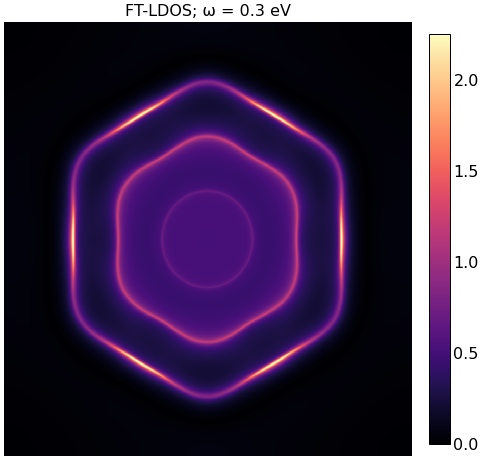

In [17]:
plt.figure(figsize=(8,8))
range1 = 0
plt.pcolormesh(k_spacex3/length,k_spacey3/length, sol/4.5*10**5, cmap = "magma", shading = 'auto', vmin = range1)
plt.title("FT-LDOS; ω = 0.3 eV")
plt.axis('off')

plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('Scalar QPI 800', bbox_inches='tight')
plt.show()

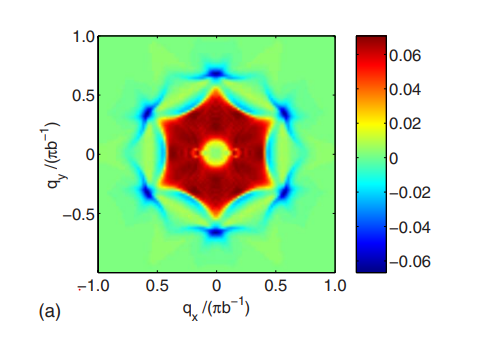